# **Background & Context**
In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


## **Dataset**

This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
images.npy
Label.csv
Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
The goal of the project is to create a classifier capable of determining a plant's species from an image.

### **List of Plant species:**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet







In [ ]:
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import tensorflow as tf

#importing the seabrn library
import seaborn as sns

# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam,SGD
# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint

Mounting the drive to load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading the Dataset**

In [ ]:
import numpy as np
import pandas as pd
images = np.load('/content/drive/My Drive/Colab Notebooks/plant_images.npy')
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant_Labels.csv')

In [ ]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [ ]:
images.shape

(4750, 128, 128, 3)

Our dataset has 4750 images fo a size 128x128 pixels and 3 image channels.

In [ ]:
labels.shape

(4750, 1)

We have all the corresponding labels for our images

## **Splitting our images and labels into test and train datasets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size = 0.2, random_state = 42,stratify = labels)

# **Exploratory Data Analysis**

## **Visualizing a random set of images along with their corresponding labels**

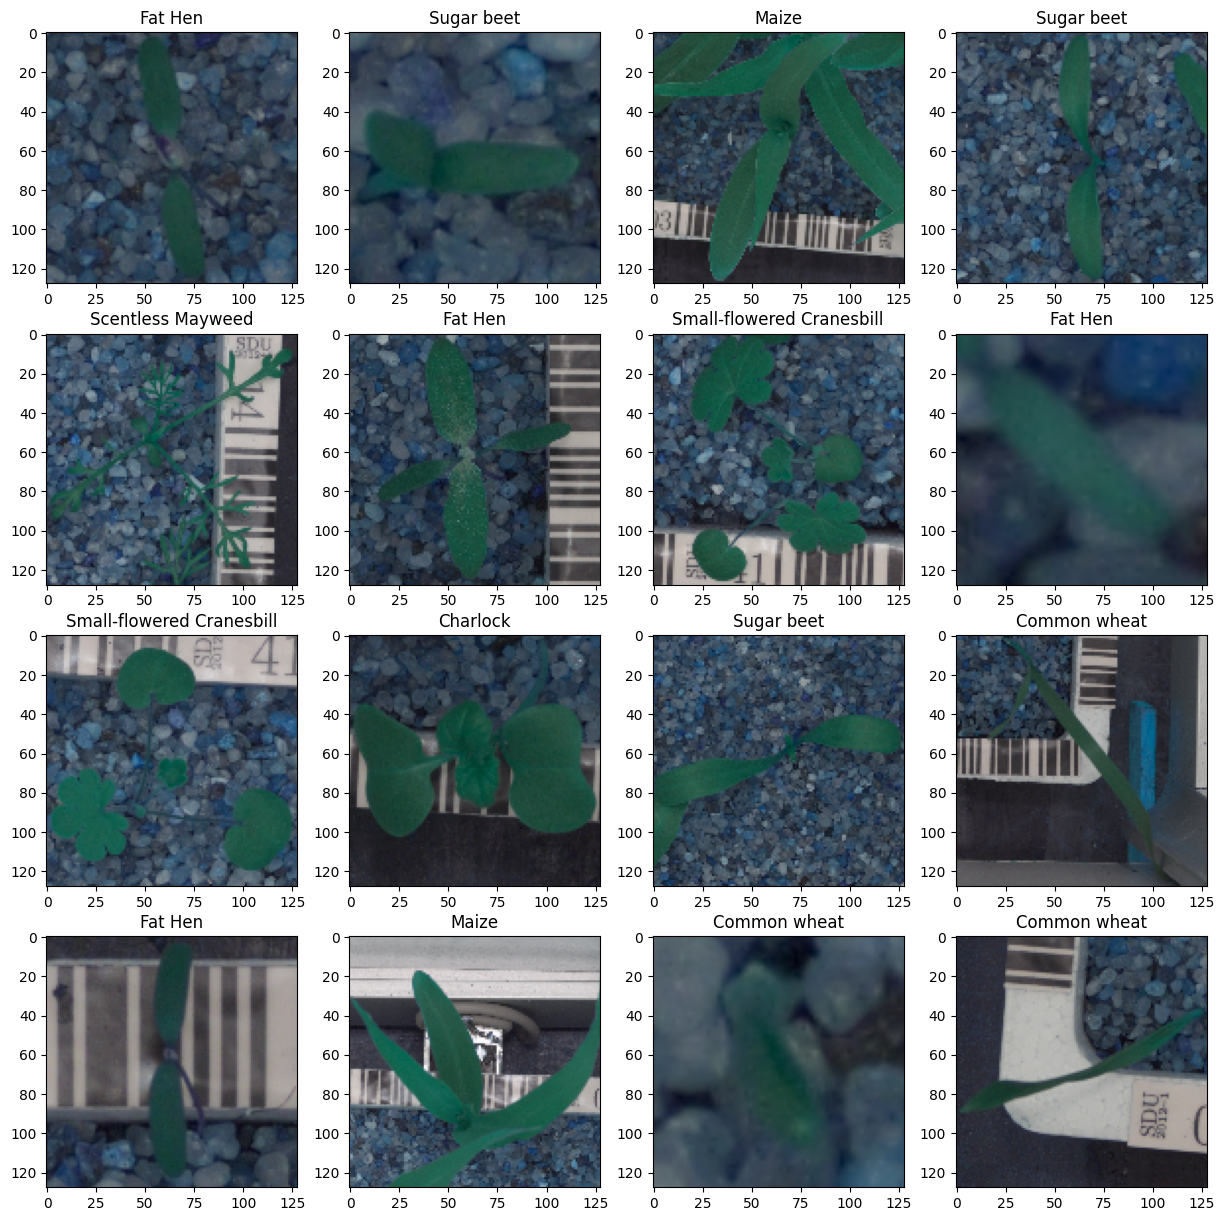

In [ ]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, 16 +1):
    random_index = np.random.randint(0, len(y_train))
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(4, 4, i)
    plt.imshow(images[random_index])
    ax = plt.subplot(4, 4, i)
    ax.set_title(labels['Label'][random_index])
plt.show()


- ALL of the images have the same measurements
- Some images are more blurred than others, and some appear more zoomed in

In [ ]:
# Function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

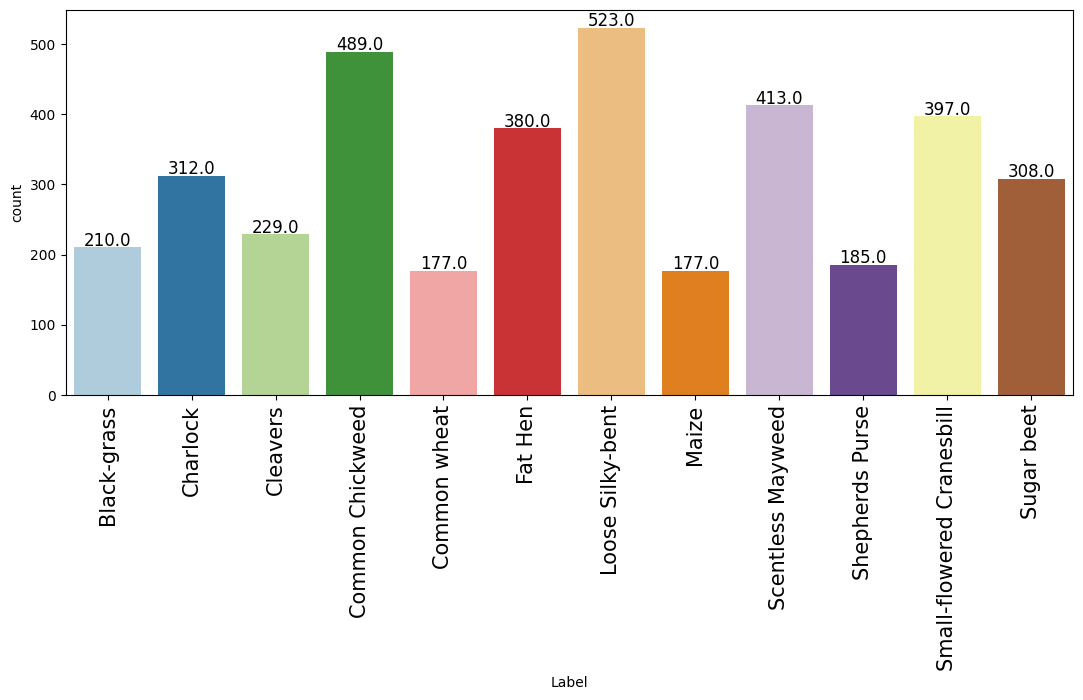

In [ ]:
labeled_barplot(y_train, 'Label')

- There is not an equal amount of images for each category
- Since there is imbalance in the number of different plant types, our model could become biased toward plants with more images in the dataset
- To prevent our model from showing bias, we can treat the class imbalance by increasing the weights of the minority classes

# **Data Preparation**

## **Treating Class Imbalance**

In [ ]:
from sklearn.utils import class_weight

#Adjusting Class Weights
labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.797649034424853,
 1: 0.8333333333333334,
 2: 1.7117117117117118,
 3: 1.7890772128060264,
 4: 0.6475800954328562,
 5: 1.014957264957265,
 6: 1.3828238719068413,
 7: 0.7667473769168685,
 8: 1.0281385281385282,
 9: 1.7890772128060264,
 10: 1.507936507936508,
 11: 0.6054811982154238}

In [ ]:
# Converting the pixel values into Numpy array
X_train= np.array(X_train)
X_test= np.array(X_test)

## **Gaussian Blurring**

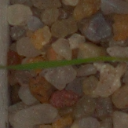

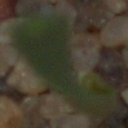

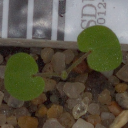

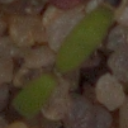

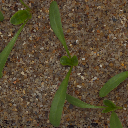

In [ ]:
from google.colab.patches import cv2_imshow
for i in range(5):
   cv2_imshow(X_train[i])
   #plt.imshow(X[i])

# Normalization

In [ ]:
images.max()

255

In [ ]:
X_train.shape

(3800, 128, 128, 3)

In [ ]:
images.shape

(4750, 128, 128, 3)

- The images have a max pixel value of 255
- so we will use Normalization to standardize the pixels to a value between 0-1

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

Since this is a **12-class classification problem**, **the output layer should have 12 neurons** which will provide us with the probabilities of the input image belonging to each of those 12 classes. Therefore, we also need to create a **one-hot encoded representation for the target classes.**

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
# create iterator
X_train_augmented = train_datagen.flow(X_train_normalized)

### **Encoding Target Variable**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
# Storing the LabelBinarizer function in lb variable
lb = LabelBinarizer()
# Applying fit_transform on train target variable
y_train_e = lb.fit_transform(y_train)
# Applying only transform on test target variable
y_test_e = lb.transform(y_test)

# **Model Building CNN**

# Model 1

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128,128,3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(100, activation='relu'))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

In [ ]:
 # Fitting the model with 30 epochs and validation_split as 10%
history_1 = model.fit(
            X_train_normalized, y_train_e,
            epochs=15,
            validation_split=0.10
)

Epoch 1/15
107/107 [==============================] - 178s 2s/step - loss: 2.4375 - accuracy: 0.1278 - val_loss: 2.3750 - val_accuracy: 0.1368
Epoch 2/15
107/107 [==============================] - 173s 2s/step - loss: 2.1989 - accuracy: 0.2368 - val_loss: 1.5848 - val_accuracy: 0.4500
Epoch 3/15
107/107 [==============================] - 175s 2s/step - loss: 1.5686 - accuracy: 0.4620 - val_loss: 1.3207 - val_accuracy: 0.5289
Epoch 4/15
107/107 [==============================] - 170s 2s/step - loss: 1.2640 - accuracy: 0.5570 - val_loss: 1.0228 - val_accuracy: 0.6421
Epoch 5/15
107/107 [==============================] - 168s 2s/step - loss: 1.0599 - accuracy: 0.6287 - val_loss: 0.9609 - val_accuracy: 0.6553
Epoch 6/15
107/107 [==============================] - 166s 2s/step - loss: 0.8979 - accuracy: 0.6789 - val_loss: 0.9077 - val_accuracy: 0.6868
Epoch 7/15
107/107 [==============================] - 175s 2s/step - loss: 0.7731 - accuracy: 0.7269 - val_loss: 0.9438 - val_accuracy: 0.6737

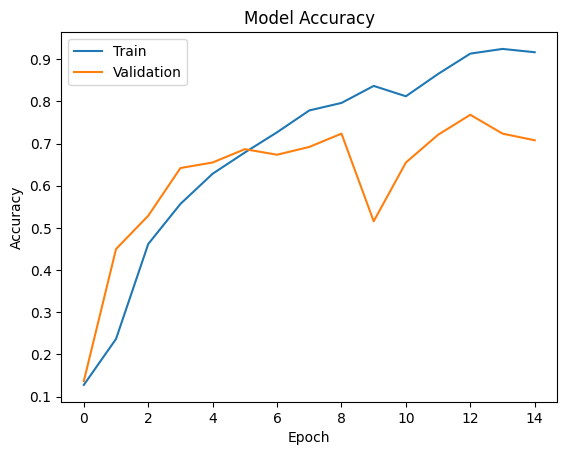

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- When evaluating our CNN model we can see that it is overfitting
- We will recreate the model, but use Batch Normalization and Spatial Dropout regularization techniques

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_e, verbose=2)

30/30 - 12s - loss: 1.1889 - accuracy: 0.7137 - 12s/epoch - 401ms/step


The model has an accuracy of 68% on our test set. An accuracy of 68% isn't that great and we can definitely improve the model

# Model 2

In model 2 we will use Batch Normalization after our convolution layers. We willl also create a second fully connected Dense layer and use spatial dropout. These normalization techniques will hopefully reduce overfitting and improve our models accuracy. I will also train the model for 30 epochs instead of 15.


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128,128,3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.25))

# Adding a fully connected dense layer with 50 neurons
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.25))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))


# Compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
 # Fitting the model with 30 epochs and validation_split as 10%
history_2 = model2.fit(
            X_train_normalized, y_train_e,
            epochs=30,
            batch_size=32,
            validation_split=0.10
)

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- The model still seems a little overfit, but let's see the model accuracy on our test data

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_e, verbose=2)

Our model has majorly improved and now has an accuracy of 76% on the test data

# **Model Comparison**

## Plots

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Accuracy

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_e, verbose=2)

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_e, verbose=2)

Model 1 had an accuracy of 68% on the test data, while model 2 had an accuracy of 76% on the test data

 # **Conclusion and Key Takeaways**

The ability to identify plants more effectively than experienced manual labor could lead to better crop yields, and free up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture.

I believe that employing model 2 for identification of plants would further the agricultural industry. An accuracy of 76% is a great value to identify plant growth in agricultural fields. With overhead imaging, farmers would be able to identify whether the machine learning model is identifying the crop yield or other weeds which could help eaily determine crop health